In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mashug","key":"b0cb73ba8464333769f9e3578f02c378"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d mashug/clearvisiondataset
!kaggle datasets download -d mashug/clearvisioncode

Dataset URL: https://www.kaggle.com/datasets/mashug/clearvisiondataset
License(s): unknown
  0% 0.00/62.7M [00:00<?, ?B/s]
100% 62.7M/62.7M [00:00<00:00, 1.35GB/s]
Dataset URL: https://www.kaggle.com/datasets/mashug/clearvisioncode
License(s): unknown
  0% 0.00/103M [00:00<?, ?B/s]
100% 103M/103M [00:00<00:00, 1.07GB/s]


In [5]:
!unzip -o clearvisioncode.zip

Streaming output truncated to the last 5000 lines.
  inflating: ClearVision_Backup/data/Clean/camera_32.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_33.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_34.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_35.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_36.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_37.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_38.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_4.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_5.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_6.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_7.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_8.jpg  
  inflating: ClearVision_Backup/data/Clean/camera_9.jpg  
  inflating: ClearVision_Backup/data/Clean/candid_street_portrait_1.jpg  
  inflating: ClearVision_Backup/data/Clean/candid_street_portrait_10.jpg  
  inflating: ClearVision_Backup/data/Cl

In [ ]:
!kaggle datasets download -d mashug/clearvisiondataset

Dataset URL: https://www.kaggle.com/datasets/mashug/clearvisiondataset
License(s): unknown
  0% 0.00/62.7M [00:00<?, ?B/s]
100% 62.7M/62.7M [00:00<00:00, 1.38GB/s]


In [6]:
import sys
sys.path.append('/content/ClearVision_Backup/ClearVision')
clean_path = '/content/Data/Clean'
corrupt_path = '/content/Data/Corrupted'

In [7]:
!pip install torch torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [10]:
from Degrador.ImageDegrador import ImageDegrador
from Degrador.PairImages import PairImages
from Scraper.scraper import Scraper
# from model.VAE import VAE
from torch.utils.data import random_split ,DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import os

In [ ]:
scrapped_path = 'content/Data/Scrapped'

search_terms = [
        # Nature & Landscapes
        "forest", "mountain", "river", "lake", "beach", "desert", "snow", "sunset", "sunrise", "sky",
        "waterfall", "cliff", "valley", "field", "rainforest", "foggy forest", "countryside", "volcano", "iceberg", "stormy sky",

        # Urban & Architecture
        "city skyline", "urban street", "skyscraper", "bridge", "building facade", "night city", "abandoned building",
        "interior design", "subway station", "apartment", "old house", "modern house", "window light", "empty room", "hotel lobby",

        # People & Portraits
        "portrait", "man face", "woman face", "smiling child", "elderly person", "person walking", "person reading",
        "silhouette", "group of people", "people in market", "candid street portrait", "close up face", "blurred person",

        # Daily Objects & Lifestyle
        "books", "laptop on desk", "coffee cup", "camera", "glasses", "shoes", "bicycle", "chair", "table", "clock",
        "phone", "headphones", "pen and notebook", "typewriter", "watch", "keys", "mirror", "umbrella", "shopping cart", "door handle",

        # Animals
        "cat", "dog", "horse", "bird", "owl", "elephant", "lion", "tiger", "monkey", "fish",
        "wild animal", "animal closeup", "farm animals", "animal eyes", "animal fur",

        # Food
        "fruits", "vegetables", "pizza", "burger", "pasta", "salad", "bread", "coffee", "tea", "ice cream",
        "kitchen interior", "table setting", "street food", "grocery store", "picnic food",

        # Transportation
        "car", "old car", "motorbike", "bicycle", "bus", "train", "airplane", "boat", "subway", "traffic jam",

        # Abstract, Texture & Patterns
        "fabric texture", "wood texture", "rusty metal", "peeling paint", "grungy wall", "glass reflection",
        "water droplets",
        "bokeh lights", "light rays", "scratched surface", "paper texture", "brick wall",
        "concrete surface", "cracked ground", "muddy surface",

        # Weather & Conditions
        "rainy day", "snowy street", "foggy morning", "storm clouds", "windy field", "misty lake",
        "overcast sky", "bright sunlight", "night fog", "dusty road",

        # Miscellaneous / High Variety
        "vintage object", "minimalist interior", "industrial scene", "colorful buildings", "market street",
        "library shelves", "playground", "school hallway", "concert crowd", "park bench"
    ]
for term in search_terms:
      scraper = Scraper(base_folder=scrapped_path, search_term=term, num_images=50)
      scraper.scrape_and_save_images()

In [ ]:
degrador = ImageDegrador(
    base_path=clean_path,
    clean_path=clean_path,
    corruption_path=corrupt_path,
    target_size=(128, 128)
)
for i in range(5):
  degrador.save_degraded_images(max_workers=os.cpu_count())

Streaming output truncated to the last 5000 lines.
Degarde Shape:torch.Size([3, 128, 128])
Input shape: torch.Size([3, 128, 128]), Kernel shape: torch.Size([5, 5])
reading stormy_sky_16.jpg
Completed ANISO
Applying N_guass
reading snow_19.jpg
torch.Size([3, 128, 128])
Applied degradations: ['B_aniso', 'B_iso']
Applying B_aniso
Input shape: torch.Size([3, 128, 128]), Kernel shape: torch.Size([5, 5])
torch.Size([3, 128, 128])
Applied degradations: ['B_aniso', 'N_jpeg']
Applying B_aniso
Completed ANISO
Applying B_iso
Input shape: torch.Size([3, 128, 128]), Kernel shape: torch.Size([5, 5])
Completed ANISO
Applying N_jpeg
completed ISO
torch.Size([3, 128, 128])
Degarde Shape:torch.Size([3, 128, 128])
completed JPEG COMPRESSION
torch.Size([3, 128, 128])
Degarde Shape:torch.Size([3, 128, 128])
reading city_skyline_2.jpg
reading waterfall_11.jpg
torch.Size([3, 128, 128])
Applied degradations: ['B_iso', 'N_guass']
Applying B_iso
torch.Size([3, 128, 128])
Applied degradations: ['N_guass', 'B_ani

Parallel Processing: 100%|██████████| 5335/5335 [00:00<00:00, 236744.45img/s]


In [9]:
fd = os.listdir(corrupt_path)
len(fd)

5335

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = PairImages(clean_path=clean_path , corrupted_path=corrupt_path , transform= transform)
print("Length of dataset:", len(dataset))  # This should work fine
x,y = dataset[0]
print(x.shape , y.shape)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
train_size = 0.8 *len( dataloader )
train_size = int(train_size)
train_dataset, val_dataset = random_split(dataset, [train_size, len(dataset) - train_size])

Length of dataset: 5335
torch.Size([3, 128, 128]) torch.Size([3, 128, 128])


In [12]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.1 MB/s eta 0:00:00


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lpips

class SpatialBroadcastDecoder(nn.Module):
    def __init__(self, latent_dim, output_size=128):
        super().__init__()
        self.latent_dim = latent_dim
        self.H = self.W = 16

        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim + 2, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 3, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        B = z.size(0)
        z_broadcast = z.view(B, self.latent_dim, 1, 1).expand(-1, -1, self.H, self.W)
        coords = self.generate_coordinate_grid(B, self.H, self.W).to(z.device)
        z = torch.cat([z_broadcast, coords], dim=1)
        return self.decoder(z)

    def generate_coordinate_grid(self,batch_size, H, W):
        y = torch.linspace(-1, 1, steps=H)
        x = torch.linspace(-1, 1, steps=W)
        yy, xx = torch.meshgrid(y, x, indexing="ij")
        coords = torch.stack([xx, yy], dim=0).unsqueeze(0).repeat(batch_size, 1, 1, 1)
        return coords

class VAE(nn.Module):
    def __init__(self,image_channels = 3, latent_dim = 128):
        super(VAE , self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels , 64 , kernel_size=4 , stride=2 , padding=1),
            nn.ReLU(),
            nn.Conv2d(64 , 128  , kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128 , 256 , kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256 , 512 , kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )


        self.flatten_dim = 512*8*8
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(self.flatten_dim , latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim , latent_dim)

        self.fc_decode = nn.Linear(latent_dim , self.flatten_dim)
        self.decoder = SpatialBroadcastDecoder(latent_dim)

    def encode(self , x):
        x = self.encoder(x)
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu , logvar

    def reparameterize(self , mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu+eps*std

    def decode(self , z):
        return self.decoder(z)

    def forward(self , x):
        mu,logvar = self.encode(x)
        z = self.reparameterize(mu=mu , logvar=logvar)
        x_recon = self.decode(z)

        return x_recon,mu,logvar

def loss_function_VAE(recon_x, x, mu, logvar, beta , free_nats = 0.5):
    recon_loss = (0.8 * F.mse_loss(recon_x, x , reduction = 'sum') + 0.2 * F.l1_loss(recon_x, x , reduction = 'sum'))

    kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl_per_dim = torch.clamp(kl_per_dim, min=free_nats)
    kl = kl_per_dim.sum()

    # print("mu mean:", mu.mean().item(), "logvar mean:", logvar.mean().item())
    var = beta
    loss = recon_loss + var*kl
    return loss,recon_loss,kl

In [14]:
import matplotlib.pyplot as plt

def show_samples(degraded, recon, clean, num=3):
    degraded = degraded[:num].cpu().permute(0, 2, 3, 1).clamp(0, 1)
    recon = recon[:num].detach().cpu().permute(0, 2, 3, 1).clamp(0, 1)
    clean = clean[:num].cpu().permute(0, 2, 3, 1).clamp(0, 1)

    fig, axes = plt.subplots(num, 3, figsize=(9, 3 * num))
    for i in range(num):
        axes[i, 0].imshow(degraded[i])
        axes[i, 0].set_title("Degraded")
        axes[i, 1].imshow(recon[i])
        axes[i, 1].set_title("Reconstructed")
        axes[i, 2].imshow(clean[i])
        axes[i, 2].set_title("Clean")
        for ax in axes[i]:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

In [15]:
import lpips

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lpips_func = lpips.LPIPS(net = 'alex').to(device)

def normalize_lpips(img):
    return 2*img - 1
def show_reconstructions(model, dataset, n=5, device='cuda'):
    model.eval()
    fig, axes = plt.subplots(n, 3, figsize=(10, 4 * n))
    psnr_total = 0
    ssim_total = 0
    lpips_total = 0

    for i in range(n):
        degraded, clean = dataset[i]

        degraded = degraded.unsqueeze(0).to(device)
        clean = clean.unsqueeze(0).to(device)

        with torch.no_grad():
            recon, _, _ = model(degraded)


        lpips_score = lpips_func(
            normalize_lpips(recon),
            normalize_lpips(clean)
        )
        lpips_total += lpips_score.item()

        recon_np = recon.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
        degraded_np = degraded.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()
        clean_np = clean.squeeze(0).detach().cpu().permute(1, 2, 0).numpy()

        psnr_total += psnr(clean_np, recon_np, data_range=1.0)
        ssim_total += ssim(clean_np, recon_np, data_range=1.0, channel_axis=-1)

        axes[i, 0].imshow(degraded_np)
        axes[i, 0].set_title("Degraded")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(recon_np)
        axes[i, 1].set_title("Reconstructed")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(clean_np)
        axes[i, 2].set_title("Clean")
        axes[i, 2].axis("off")

    avg_psnr = psnr_total / n
    avg_ssim = ssim_total / n
    avg_lpips = lpips_total / n

    print(f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}, Average LPIPS: {avg_lpips:.4f}")
    plt.tight_layout()
    plt.show()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 65.4MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
import math
def kl_annealing(epoch, warmup_epochs=50, max_beta=0.7):
    return min(max_beta, epoch / warmup_epochs * max_beta)

def get_cyclical_beta(epoch, cycle_length=20, max_beta=1.0):
    cycle_pos = epoch % cycle_length / cycle_length
    return max_beta * (0.5 - 0.5 * math.cos(math.pi * cycle_pos))

model = VAE(latent_dim = 128)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
for epoch in range(epochs):
  model.train()
  total_loss = 0
  total_recon =0
  total_kl = 0
  beta = min(1.0, epoch / 10)
  lpips_weight = kl_annealing(epoch)
  for degraded,clean in dataloader:
    # Move data to the appropriate device
    degraded = degraded.to(device)
    clean = clean.to(device)

    optimizer.zero_grad()
    recon_batch, mu, logvar = model(degraded)
    loss,recon_loss,kl= loss_function_VAE(
            recon_x=recon_batch,
            x=clean,
            mu=mu,
            logvar=logvar,
            beta=beta,
            lpips_func = lpips_func,
            lpips_weight = lpips_weight,
        )
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    total_recon += recon_loss.item()
    total_kl += kl.item()
  print(f"Epoch [{epoch + 1}/{epochs}] Loss: {total_loss / len(dataset):.4f},Recon:{total_recon/len(dataset):.4f} , KL:{total_kl/len(dataset):.4f}")
  print("mu mean:", mu.mean().item(), "logvar mean:", logvar.mean().item())
  if (epoch+1) % 10 == 0:
    show_reconstructions(model, dataset)
  with torch.no_grad():
    std_vals = logvar.exp().sqrt().mean(dim=0)
    active_dims = (std_vals > 0.1).sum().item()
    print(f"Active latent dims: {active_dims}/{128}")

False
Epoch [1/100] Loss: 16390.4817
Epoch [2/100] Loss: 12697.1265
Epoch [3/100] Loss: 11875.2066
Epoch [4/100] Loss: 11528.1212
Epoch [5/100] Loss: 11229.8936
Epoch [6/100] Loss: 10985.5065
Epoch [7/100] Loss: 10867.2424
Epoch [8/100] Loss: 10780.5218
Epoch [9/100] Loss: 10709.5229
Epoch [10/100] Loss: 10649.8657
Epoch [11/100] Loss: 10592.0472
Epoch [12/100] Loss: 10568.4352
Epoch [13/100] Loss: 10506.0330
Epoch [14/100] Loss: 10467.2825
Epoch [15/100] Loss: 10438.3160
Epoch [16/100] Loss: 10393.1620
Epoch [17/100] Loss: 10372.7636
Epoch [18/100] Loss: 10334.5396
Epoch [19/100] Loss: 10296.3018
Epoch [20/100] Loss: 10292.3228
Epoch [21/100] Loss: 10254.6300
Epoch [22/100] Loss: 10227.1480
Epoch [23/100] Loss: 10202.5161
Epoch [24/100] Loss: 10192.4662
Epoch [25/100] Loss: 10169.0343
Epoch [26/100] Loss: 10150.5245
Epoch [27/100] Loss: 10140.8670
Epoch [28/100] Loss: 10128.4957
Epoch [29/100] Loss: 10109.1026
Epoch [30/100] Loss: 10102.6033
Epoch [31/100] Loss: 10081.9193
Epoch [32/1

In [ ]:
os.makedirs("/content/ClearVision/model", exist_ok=True)
torch.save(model.state_dict(), "/content/ClearVision/model/vae_model.pth")

In [16]:
import matplotlib.pyplot as plt
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips

def show_reconstructions(model, dataset, n=5, device='cuda'):
    """Enhanced reconstruction visualizer with metrics for VQ-VAE"""
    model.eval()
    fig, axes = plt.subplots(n, 3, figsize=(12, 3.5 * n))

    # Metrics
    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0
    }

    # LPIPS setup
    lpips_fn = lpips.LPIPS(net='alex').to(device)

    with torch.no_grad():
        for i in range(n):
            degraded, clean = dataset[i]
            degraded = degraded.unsqueeze(0).to(device)
            clean = clean.unsqueeze(0).to(device)

            # Forward pass (matches VQ-VAE return signature)
            recon, _, _ = model(degraded)

            # Calculate metrics
            metrics['psnr'] += psnr(
                clean.cpu().numpy().squeeze().transpose(1,2,0),
                recon.cpu().numpy().squeeze().transpose(1,2,0),
                data_range=1.0
            )

            metrics['ssim'] += ssim(
                clean.cpu().numpy().squeeze().transpose(1,2,0),
                recon.cpu().numpy().squeeze().transpose(1,2,0),
                data_range=1.0,
                channel_axis=-1
            )

            metrics['lpips'] += lpips_fn(
                2*recon - 1,  # LPIPS expects [-1,1]
                2*clean - 1
            ).item()

            # Visualization
            for j, img in enumerate([degraded, recon, clean]):
                axes[i,j].imshow(img.squeeze(0).cpu().permute(1,2,0).clip(0,1))
                axes[i,j].axis('off')

            axes[i,0].set_title('Degraded')
            axes[i,1].set_title('Reconstructed')
            axes[i,2].set_title('Clean')

    # Print metrics
    print(f"Average Metrics (n={n}):")
    print(f"PSNR: {metrics['psnr']/n:.2f} dB")
    print(f"SSIM: {metrics['ssim']/n:.4f}")
    print(f"LPIPS: {metrics['lpips']/n:.4f}")

    plt.tight_layout()
    plt.show()

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=256, embedding_dim=64, commitment_cost=0.001):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost

        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        nn.init.uniform_(self.codebook.weight, -0.1 , 0.1)

        self.register_buffer('usage', torch.zeros(num_embeddings))
        self.register_buffer('last_usage', torch.zeros(num_embeddings))

    def forward(self, z):
        B, D, H, W = z.shape
        assert D == self.embedding_dim, f"Expected dim {self.embedding_dim}, got {D}"

        z_flattened = z.permute(0, 2, 3, 1).contiguous().view(-1, D)
        z_normalized = F.layer_norm(z_flattened, [D])

        distances = (
            torch.sum(z_normalized**2, dim=1, keepdim=True) +
            torch.sum(self.codebook.weight**2, dim=1) -
            2 * torch.matmul(z_normalized, self.codebook.weight.t()))

        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).float()
        z_q = torch.matmul(encodings, self.codebook.weight).view(B, H, W, D).permute(0, 3, 1, 2)


        codebook_loss = F.mse_loss(z_q.detach(), z)
        commitment_loss = F.mse_loss(z, z_q.detach())

        self.last_usage = torch.sum(encodings, dim=0)
        self.usage += self.last_usage
        usage_pct = 100 * torch.sum(self.last_usage > 0).item() / self.num_embeddings

        z_q = z + (z_q - z).detach()

        return z_q, codebook_loss + self.commitment_cost * commitment_loss, usage_pct

In [18]:
class EMAQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25, decay=0.99, epsilon=1e-5):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        self.embeddings = nn.Parameter(
            torch.randn(num_embeddings, embedding_dim) * 0.1
        )

        nn.init.uniform_(self.embeddings, -1.0, 1.0)
        self.embeddings.requires_grad = False

        self.register_buffer('cluster_size', torch.zeros(num_embeddings))
        self.register_buffer('ema_w', torch.randn(num_embeddings, embedding_dim))
        self.register_buffer('usage', torch.zeros(num_embeddings))

    def forward(self, z):
        B, C, H, W = z.shape
        z_flattened = z.permute(0, 2, 3, 1).reshape(-1, C)

        distances = (
            z_flattened.pow(2).sum(1, keepdim=True) -
            2 * z_flattened @ self.embeddings.t() +
            self.embeddings.pow(2).sum(1)
        )
        noise_scale = 0.1 * distances.std().detach()
        distances = distances + noise_scale * torch.randn_like(distances)

        encoding_indices = torch.argmin(distances, dim=1)
        encodings = F.one_hot(encoding_indices, self.num_embeddings).type(z.dtype)

        quantized = encodings @ self.embeddings
        quantized = quantized.view(B, H, W, C).permute(0, 3, 1, 2)

        if self.training:
            encoding_counts = encodings.sum(0)
            self.usage = encoding_counts.detach().clone()
            self.cluster_size.data.mul_(self.decay).add_(encoding_counts, alpha=1 - self.decay)

            embed_sum = encodings.T @ z_flattened
            self.ema_w.data.mul_(self.decay).add_(embed_sum, alpha=1 - self.decay)

            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.epsilon) /
                (n + self.num_embeddings * self.epsilon) * n
            )
            self.embeddings.data = self.ema_w / cluster_size.unsqueeze(1)

        e_latent_loss = F.mse_loss(z, quantized.detach())*5.0

        code_probs = torch.softmax(-distances, dim=1).mean(dim=0)
        diversity_loss = -(code_probs * torch.log(code_probs + 1e-10)).mean()

        loss = self.commitment_cost * e_latent_loss + 0.1*diversity_loss

        quantized = z + (quantized - z).detach()

        usage = 100 * (self.cluster_size > 0.1).float().mean().item()

        return quantized, loss, usage


In [19]:
class EMAVAE(nn.Module):
    def __init__(self, image_channels=3, latent_dim=64, num_embeddings=256):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            ResidualBlock(64),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            ResidualBlock(128),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.GroupNorm(8, 256),
            nn.LeakyReLU(0.2),
            ResidualBlock(256),
            nn.Conv2d(256, latent_dim, 1)
        )

        self.quantizer = EMAQuantizer(
            num_embeddings=num_embeddings,
            embedding_dim=latent_dim,
            commitment_cost=0.25,
            decay=0.9
        )
        self.decoder = nn.Sequential(
            # nn.Conv2d(256 + 2, 128, 3, padding=1),  # 256 latent + 2 coord channels
            # ResidualBlock(128),
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(128, 64, 3, padding=1),
            # ResidualBlock(64),
            # nn.Upsample(scale_factor=2),
            # nn.Conv2d(64, 3, 3, padding=1),
            # nn.Tanh()

            nn.Conv2d(latent_dim + 2, 256, 1),  # +2 for coord channels
            ResidualBlock(256),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.LeakyReLU(0.2),
            ResidualBlock(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.2),
            ResidualBlock(64),
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Tanh()

        )

        self.register_buffer('coord_grid', self._create_coord_grid(32))  # For 32x32 latent space

    def _create_coord_grid(self, size):
        """Create normalized coordinate grid [-1,1] for spatial broadcast"""
        y = torch.linspace(-1, 1, steps=size)
        x = torch.linspace(-1, 1, steps=size)
        yy, xx = torch.meshgrid(y, x, indexing="ij")
        return torch.stack([xx, yy], dim=0).unsqueeze(0)  # [1, 2, H, W]

    def encode(self, x):
        z = self.encoder(x)
        z_q, vq_loss, usage = self.quantizer(z)
        return z_q, vq_loss, usage

    def decode(self, z):
        """Add spatial coordinates to latent features"""
        B = z.size(0)
        coords = self.coord_grid.expand(B, -1, -1, -1)
        z = torch.cat([z, coords], dim=1)
        return self.decoder(z)

    def forward(self, x):
        z_q, vq_loss, usage = self.encode(x)
        x_recon = self.decode(z_q)
        return x_recon, vq_loss, usage

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(channels, channels, 3, padding=1)
        )
    def forward(self, x):
        return x + self.conv(x)

In [20]:

def analyze_model(model, test_input):
    with torch.no_grad():
        # 1. Check encoder outputs
        z = model.encoder(test_input)
        print(f"Encoder out - mean: {z.mean():.4f}, std: {z.std():.4f}")

        # 2. Visualize code assignments
        _, _, H, W = z.shape
        distances = torch.cdist(z.flatten(2).permute(0,2,1),
                     model.quantizer.embeddings)
        plt.imshow(distances.argmin(2).view(H,W).cpu())
        plt.title("Code Assignments")
        plt.show()

        # 3. Random code reconstruction
        rand_codes = torch.randint(0, model.quantizer.num_embeddings, (1,H,W))
        rand_recon = model.decode(model.quantizer.embeddings[rand_codes].permute(0,3,1,2))
        show_images(test_input[0], rand_recon[0])

In [21]:
def replace_dead_codes(model, min_usage=0.5):
    quantizer = model.quantizer
    if hasattr(quantizer, 'usage'):
        dead_codes = (quantizer.usage < min_usage).nonzero(as_tuple=True)[0]
        if len(dead_codes) > 0:
            with torch.no_grad():
                new_embeds = torch.randn_like(quantizer.embeddings[dead_codes])
                quantizer.embeddings[dead_codes] = new_embeds
                quantizer.usage[dead_codes] = 0  # Reset usage counter
            print(f"Reinitialized {len(dead_codes)} dead codes.")
    else:
        print("Quantizer does not track usage.")


In [ ]:
model = EMAVAE(latent_dim=64, num_embeddings=128).cuda()
optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 3e-4},
    {'params': model.quantizer.parameters(), 'lr': 6e-4},  # Higher LR
    {'params': model.decoder.parameters(), 'lr': 3e-4}
], weight_decay=1e-5)


scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(dataloader),
    epochs=100,
    pct_start=0.3,
    div_factor=25,
    final_div_factor=100
)

def loss_function(recon, target, vq_loss, lpips_func = None, epoch = 0):
    mse_loss = F.mse_loss(recon, target)
    l1_loss = F.l1_loss(recon, target)
    recon_loss = 0.7 * mse_loss + 0.3 * l1_loss

    if vq_loss.dim() > 0:
        vq_loss = vq_loss.mean()
    vq_weight = min(0.5, epoch / 10)
    vq_loss = max(vq_loss, 1e-4)
    weighted_vq_loss = vq_weight * vq_loss

    lpips_loss = torch.tensor(0.0, device=recon.device)
    if lpips_func and epoch and epoch > 10:
        lpips_loss = 0.1 * lpips_func(2*recon-1, 2*target-1).mean()

    total_loss = 0.7*mse_loss + 0.3*l1_loss + 0.1*vq_loss + lpips_loss

    return total_loss, {
        'total': total_loss.item(),
        'recon': recon_loss.item(),
        'vq': weighted_vq_loss.item(),
        'lpips': lpips_loss.item()
    }

for epoch in range(100):
    model.train()
    total_loss = 0.0
    total_vq_loss = 0.0
    total_recon_loss = 0.0
    total_usage = 0.0

    for x, _ in dataloader:
        x = x.cuda()
        _ = _.cuda()
        recon_x, vq_loss, usage = model(x)

        loss , loss_dict= loss_function(recon_x , _ , vq_loss,lpips_func = lpips_func , epoch=epoch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        total_vq_loss += loss_dict['vq']
        total_usage += usage
        total_recon_loss += loss_dict['recon']

    avg_loss = total_loss / len(dataloader)
    avg_vq_loss = total_vq_loss / len(dataloader)
    avg_usage = total_usage / len(dataloader)
    avg_recon_loss = total_recon_loss / len(dataloader)
    print(
        f"Epoch [{epoch+1}/100] "
        f"Loss: {avg_loss:.4f}, "
        f"VQ Loss: {avg_vq_loss:.4f}, "
        f"Recon Loss: {avg_recon_loss:0.4f},"
        f"Codebook Usage: {avg_usage:.1f}%"
    )
    z, _ = model.encoder(x[:1])
    print(f"Encoder output - mean: {z.mean().item():.4f}, std: {z.std().item():.4f}")

    if epoch % 5 == 0:
        show_reconstructions(model , dataset , n=3 , device = device)
        used_codes = (model.quantizer.usage > 0).sum().item()
        total_codes = model.quantizer.num_embeddings
        print(f"Active codes: {used_codes}/{total_codes}")

        with torch.no_grad():
                usage_counts = model.quantizer.cluster_size  # Use EMA cluster size instead
                dead_codes = (usage_counts < 1e-3).nonzero(as_tuple=True)[0]

                if len(dead_codes) > 0:
                    active_mean = model.quantizer.embeddings[usage_counts > 0].mean(dim=0)
                    active_std = model.quantizer.embeddings[usage_counts > 0].std(dim=0)
                    model.quantizer.embeddings[dead_codes] = active_mean + 0.2*active_std*torch.randn_like(model.quantizer.embeddings[dead_codes])
                    print(f"Reinitialized {len(dead_codes)} dead codes near active distribution")


    if epoch % 10 == 0:
        replace_dead_codes(model)

Epoch [1/100] Loss: 0.5219, VQ Loss: 0.0000, Recon Loss: 0.2981,Codebook Usage: 57.5%


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
os.makedirs("/kaggle/working/ClearVision/model", exist_ok=True)
torch.save(model.state_dict(), "/kaggle/working/ClearVision/model/ema_unet_vqvae_model.pth")

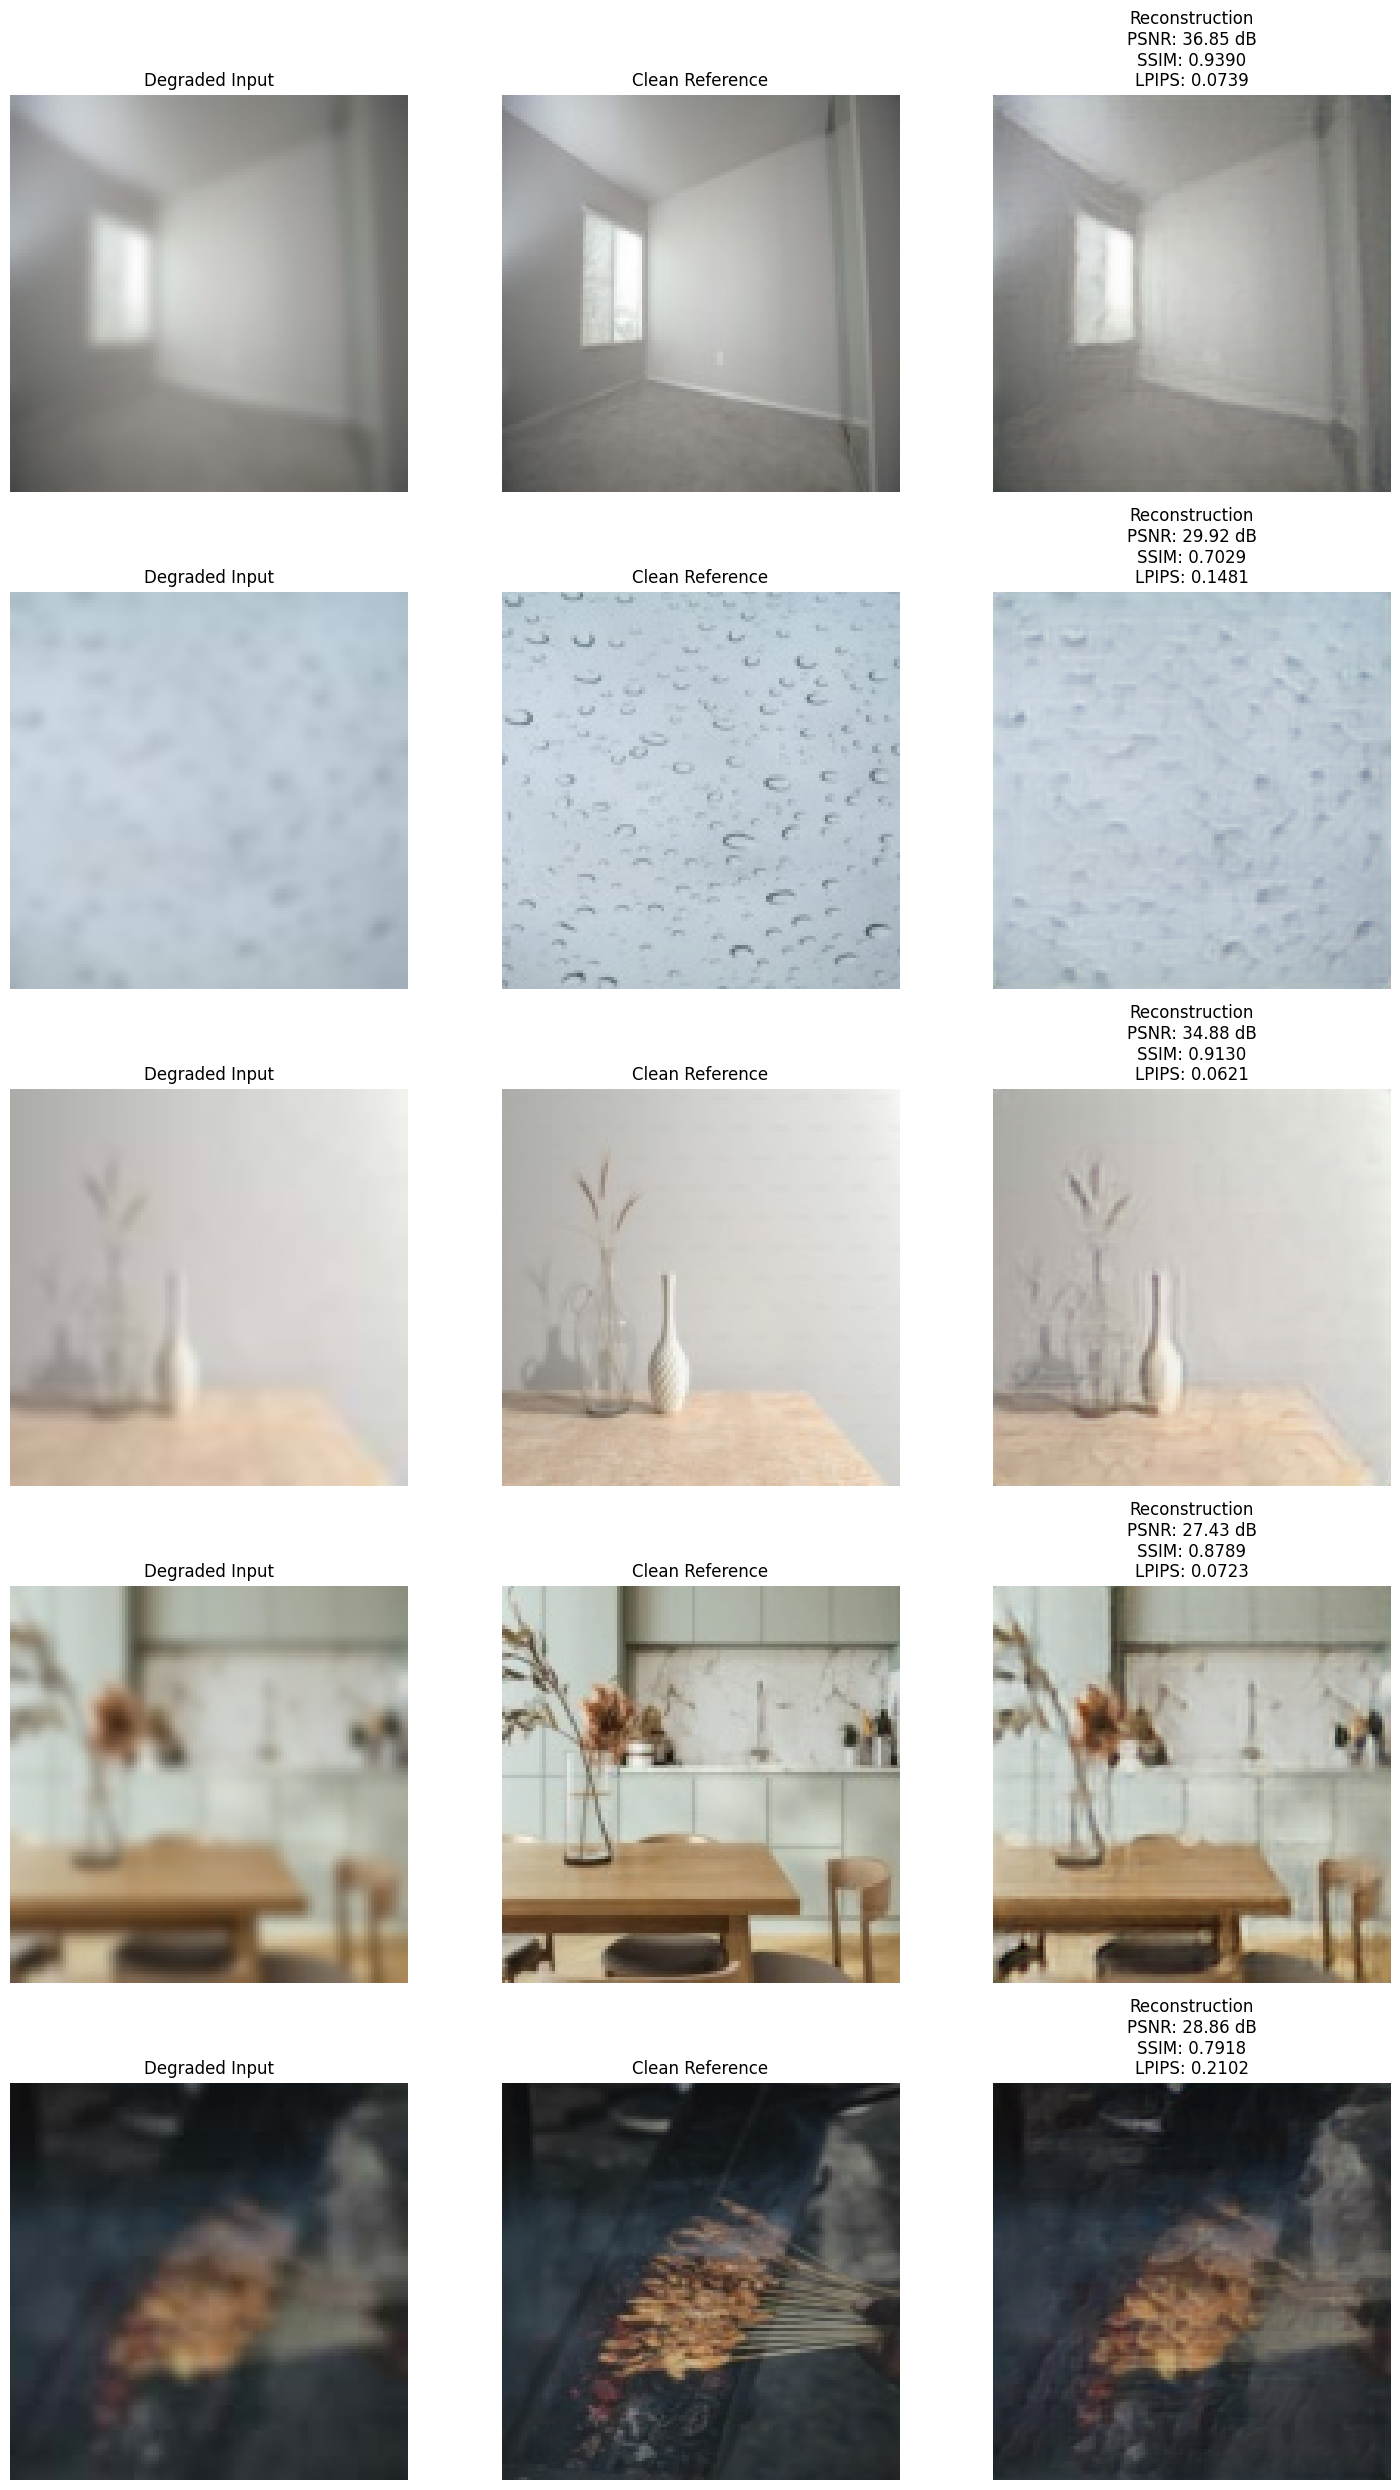


Average Metrics:
PSNR: 31.59 dB
SSIM: 0.8451
LPIPS: 0.1133


In [ ]:
show_reconstructions(model , dataset , n=5 , device = device)

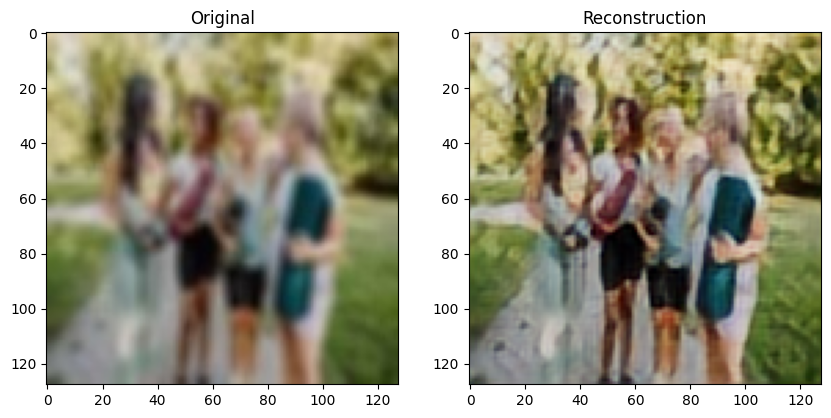

In [ ]:
model.eval()
with torch.no_grad():
    test_sample = dataset[0][0].unsqueeze(0).cuda()
    recon = model(test_sample)[0]

    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(test_sample[0].cpu().permute(1,2,0))
    ax[0].set_title('Original')
    ax[1].imshow(recon[0].cpu().permute(1,2,0))
    ax[1].set_title('Reconstruction')
    plt.show()

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lpips

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.GroupNorm(8, channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.GroupNorm(8, channels)
        )

    def forward(self, x):
        return x + self.block(x)

class EncoderWithSkips(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        self.res1 = ResidualBlock(64)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2)
        )
        self.res2 = ResidualBlock(128)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.GroupNorm(8, 256),
            nn.LeakyReLU(0.2),
            ResidualBlock(256),
            nn.Conv2d(256, 64, 1)
        )

    def forward(self, x):

        x1 = self.conv1(x)
        x1_skip = self.res1(x1)


        x2 = self.conv2(x1_skip)
        x2_skip = self.res2(x2)

        z = self.bottleneck(x2_skip)

        return z, [x1_skip, x2_skip]

class UNetDecoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()

        self.init_conv = nn.Conv2d(latent_dim + 2, 256, 1)

        self.up1 = nn.Sequential(
            nn.Conv2d(256 + 64, 128, 3, padding=1),
            nn.GroupNorm(8, 128),
            nn.LeakyReLU(0.2),
            ResidualBlock(128)
        )
        self.up2 = nn.Sequential(
            nn.Conv2d(128 + 128, 64, 3, padding=1),
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.2),
            ResidualBlock(64)
        )

        self.final_conv = nn.Conv2d(64, 3, 3, padding=1)

    def forward(self, z, skips):
        """z: [B, 64, 32, 32]
           skips: [x1_skip (B,64,64,64), x2_skip (B,128,32,32)]"""
        x1_skip, x2_skip = skips

        x = self.init_conv(z)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, x1_skip], dim=1)
        x = self.up1(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat([x, F.interpolate(x2_skip, scale_factor=4, mode='bilinear', align_corners=False)], dim=1)
        x = self.up2(x)

        return torch.tanh(self.final_conv(x))

class EMA_UNET_VAE(nn.Module):
    def __init__(self, image_channels=3, latent_dim=64, num_embeddings=256):
        super().__init__()
        self.encoder = EncoderWithSkips()
        self.quantizer = EMAQuantizer(num_embeddings, embedding_dim=latent_dim,
                                      commitment_cost=0.25,
                                      decay=0.9, epsilon=1e-5)

        # Create coordinate grid matching the latent space size (32x32)
        self.register_buffer('coord_grid', self._create_coord_grid(32))
        self.decoder = UNetDecoder(latent_dim)

    def _create_coord_grid(self, size):
        y = torch.linspace(-1, 1, steps=size)
        x = torch.linspace(-1, 1, steps=size)
        yy, xx = torch.meshgrid(y, x, indexing="ij")
        return torch.stack([xx, yy], dim=0).unsqueeze(0)
    def encode(self, x):
        z, skips = self.encoder(x)
        z_q, vq_loss, usage = self.quantizer(z)
        return z_q, vq_loss, usage, skips

    def decode(self, z, skips):
        B = z.size(0)
        coords = self.coord_grid.expand(B, -1, -1, -1)
        z = torch.cat([z, coords], dim=1)
        return self.decoder(z, skips)

    def forward(self, x):
        z_q, vq_loss, usage, skips = self.encode(x)
        recon = self.decode(z_q, skips)
        return recon, vq_loss, usage

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import math
import torch
import torch.nn.functional as F

def show_reconstructions(model, dataset, n=3, device='cuda'):
    """Show side-by-side comparisons of degraded, clean and reconstructed images with metrics"""
    model.eval()
    metrics = {
        'psnr': [],
        'ssim': [],
        'lpips': []
    }

    lpips_model = None
    if 'lpips_func' in globals():
        lpips_model = lpips_func
        lpips_model.eval()

    with torch.no_grad():
        fig, axes = plt.subplots(n, 3, figsize=(15, n*5))
        if n == 1:
            axes = axes[np.newaxis, :]

        for i in range(n):
            idx = torch.randint(0, len(dataset), (1,)).item()
            degraded, clean = dataset[idx]
            degraded = degraded.unsqueeze(0).to(device)
            clean = clean.unsqueeze(0).to(device)

            outputs = model(degraded)
            recon = outputs[0]

            mse = F.mse_loss(recon, clean).item()
            psnr = -10 * math.log10(mse) if mse > 0 else float('inf')
            metrics['psnr'].append(psnr)

            degraded_img = degraded.squeeze().cpu().numpy().transpose(1, 2, 0)
            clean_img = clean.squeeze().cpu().numpy().transpose(1, 2, 0)
            recon_img = recon.squeeze().cpu().numpy().transpose(1, 2, 0)

            ssim_val = ssim(
                clean_img,
                recon_img,
                channel_axis=-1,
                data_range=1.0
            )
            metrics['ssim'].append(ssim_val)

            if lpips_model:
                lpips_val = lpips_model(
                    2*recon-1,  # Scale to [-1,1]
                    2*clean-1
                ).item()
                metrics['lpips'].append(lpips_val)

            for img in [degraded_img, clean_img, recon_img]:
                np.clip(img, 0, 1, out=img)

            axes[i,0].imshow(degraded_img)
            axes[i,0].set_title("Degraded Input", fontsize=12)
            axes[i,0].axis('off')

            axes[i,1].imshow(clean_img)
            axes[i,1].set_title("Clean Reference", fontsize=12)
            axes[i,1].axis('off')

            title = f"Reconstruction\nPSNR: {psnr:.2f} dB\nSSIM: {ssim_val:.4f}"
            if lpips_model:
                title += f"\nLPIPS: {lpips_val:.4f}"
            axes[i,2].imshow(recon_img)
            axes[i,2].set_title(title, fontsize=12)
            axes[i,2].axis('off')

        plt.tight_layout()
        plt.show()

        print("\nAverage Metrics:")
        print(f"PSNR: {np.mean(metrics['psnr']):.2f} dB")
        print(f"SSIM: {np.mean(metrics['ssim']):.4f}")
        if lpips_model and metrics['lpips']:
            print(f"LPIPS: {np.mean(metrics['lpips']):.4f}")

    model.train()

Epoch [1/100] Loss: 0.0535, VQ Loss: 0.0025, Recon Loss: 0.0510, Codebook Usage: 74.5%


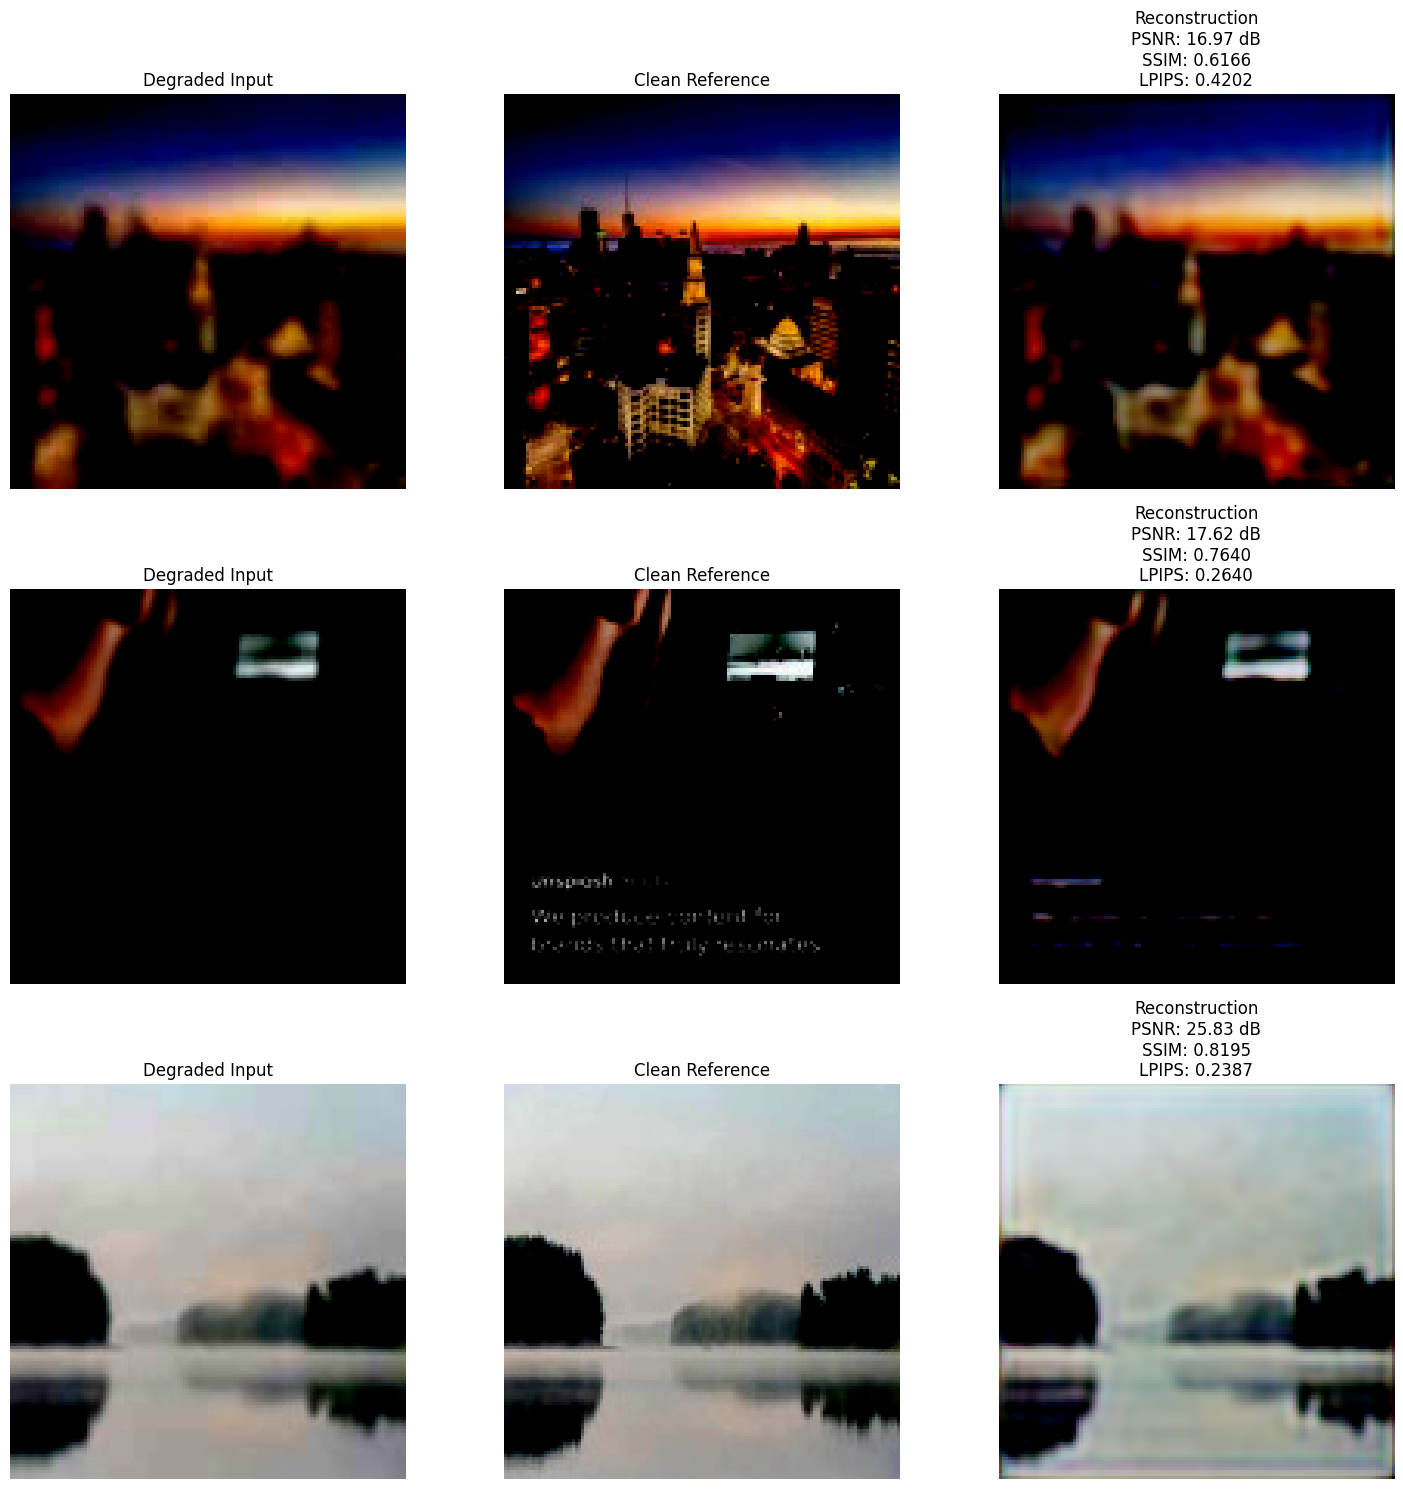


Average Metrics:
PSNR: 20.14 dB
SSIM: 0.7334
LPIPS: 0.3076
Active codes: 118/128
Reinitialized 10 dead codes near active distribution
Reinitialized 10 dead codes.
Epoch [2/100] Loss: 0.0245, VQ Loss: 0.0002, Recon Loss: 0.0243, Codebook Usage: 94.2%
Epoch [3/100] Loss: 0.0232, VQ Loss: 0.0003, Recon Loss: 0.0230, Codebook Usage: 94.5%
Epoch [4/100] Loss: 0.0218, VQ Loss: 0.0003, Recon Loss: 0.0216, Codebook Usage: 94.5%


In [ ]:

model = EMA_UNET_VAE(latent_dim=64, num_embeddings=128).cuda()

optimizer = torch.optim.AdamW([
    {'params': model.encoder.parameters(), 'lr': 3e-4},
    {'params': model.quantizer.parameters(), 'lr': 6e-4},
    {'params': model.decoder.parameters(), 'lr': 3e-4}
], weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    steps_per_epoch=len(dataloader),
    epochs=100,
    pct_start=0.3,
    div_factor=25,
    final_div_factor=100
)

def loss_function(recon, target, vq_loss, lpips_func=None, epoch=0):
    mse_loss = F.mse_loss(recon, target)
    l1_loss = F.l1_loss(recon, target)
    recon_loss = 0.8 * mse_loss + 0.2 * l1_loss

    if vq_loss.dim() > 0:
        vq_loss = vq_loss.mean()
    vq_weight = min(0.25, epoch/20 * 0.2) if epoch else 0.01
    weighted_vq_loss = vq_weight * vq_loss
    lpips_loss = torch.tensor(0.0, device=recon.device)
    if lpips_func and epoch and epoch > 10:
        lpips_loss = 0.1 * lpips_func(2*recon-1, 2*target-1).mean()

    total_loss = recon_loss + weighted_vq_loss + lpips_loss

    return total_loss, {
        'total': total_loss.item(),
        'recon': recon_loss.item(),
        'vq': weighted_vq_loss.item(),
        'lpips': lpips_loss.item()
    }

# Training loop
for epoch in range(100):
    model.train()
    total_loss = 0.0
    total_vq_loss = 0.0
    total_recon_loss = 0.0
    total_usage = 0.0

    for x, _ in dataloader:
        x = x.cuda()
        _ = _.cuda()
        recon_x, vq_loss, usage = model(x)

        loss, loss_dict = loss_function(recon_x, _, vq_loss, lpips_func=lpips_func, epoch=epoch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss_dict['total']
        total_vq_loss += loss_dict['vq']
        total_usage += usage
        total_recon_loss += loss_dict['recon']

    avg_loss = total_loss / len(dataloader)
    avg_vq_loss = total_vq_loss / len(dataloader)
    avg_usage = total_usage / len(dataloader)
    avg_recon_loss = total_recon_loss / len(dataloader)

    print(
        f"Epoch [{epoch+1}/100] "
        f"Loss: {avg_loss:.4f}, "
        f"VQ Loss: {avg_vq_loss:.4f}, "
        f"Recon Loss: {avg_recon_loss:.4f}, "
        f"Codebook Usage: {avg_usage:.1f}%"
    )
    # codebook_grad = model.quantizer.embeddings.grad
    # print(f"Codebook Grad: {codebook_grad.abs().mean().item() if codebook_grad is not None else 0:.3e}")
    # print(f"Encoder->Quantizer Grad: {z.grad.abs().mean().item():.3e}")


    if epoch % 5 == 0:
        show_reconstructions(model, dataset, n=3)

        used_codes = (model.quantizer.usage > 0).sum().item()
        total_codes = model.quantizer.num_embeddings
        print(f"Active codes: {used_codes}/{total_codes}")

        with torch.no_grad():
                # Get usage counts properly
                usage_counts = model.quantizer.cluster_size  # Use EMA cluster size instead
                dead_codes = (usage_counts < 1e-3).nonzero(as_tuple=True)[0]

                if len(dead_codes) > 0:
                    # Smart reinitialization near active codes
                    active_mean = model.quantizer.embeddings[usage_counts > 0].mean(dim=0)
                    active_std = model.quantizer.embeddings[usage_counts > 0].std(dim=0)
                    model.quantizer.embeddings[dead_codes] = active_mean + 0.2*active_std*torch.randn_like(model.quantizer.embeddings[dead_codes])
                    print(f"Reinitialized {len(dead_codes)} dead codes near active distribution")


    if epoch % 10 == 0:
        replace_dead_codes(model)

In [ ]:
model.eval()
with torch.no_grad():
    test_sample = dataset[0][0].unsqueeze(0).cuda()
    recon = model(test_sample)[0]

    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(test_sample[0].cpu().permute(1,2,0))
    ax[0].set_title('Original')
    ax[1].imshow(recon[0].cpu().permute(1,2,0))
    ax[1].set_title('Reconstruction')
    plt.show()